# Piezoelectric Microcantilever Data Generator

## 1. 物理常数与参数设置

### 1.1 物理常数（固定不变）

| 名称             | 变量名      | 数值            | 单位    | 含义         |
|------------------|-------------|-----------------|---------|--------------|
| 杨氏模量         | `E`         | 169e9           | Pa      | 弹性模量     |
| 材料密度         | `rho`       | 2330            | kg/m³   | 硅密度       |
| 梁厚度           | `t`         | 25e-6           | m       | 梁截面厚度   |
| 真空介电常数     | `eps_0`     | 8.85e-12        | F/m     | 电场常数     |
| 第一模态参数     | `beta`      | 4.73      | -       | 固定根值     |

### 1.2 结构/电气参数（可扩展为变量）

| 名称               | 变量名            | 当前数值       | 单位   |采样点数| 说明              | 采样范围             |
|--------------------|-------------------|---------------|--------|------|-------------------|-------------------------|
| 梁宽               | `w_t`             | 10e-6         | m      | 16|梁的横向宽度      | [5e-6, 20e-6]           |
| 梁长               | `l_t`             | 500e-6        | m      | 19|梁的长度          | [100e-6, 1000e-6]       |
| 驱动电压           | `V`               | 5             | V      | 10|DC激励电压        | [1, 10]                 |
| 电极间隙           | `d`               | 6e-6          | m      | 9|顶/底电极间距     | [2e-6, 10e-6]           |
| 电极长度           | `electrode_length`| 700e-6        | m      | 81|电极长度          | [100e-6, 900e-6]        |
| 电极宽度           | `electrode_width` | 20e-6         | m      | 26|电极宽度          | [5e-6, 30e-6]           |
| 端部质量块宽度     | `w_c`             | 10e-6         | m      | 76|末端质量块宽度    | [5e-6, 20e-6]           |
| 端部质量块长度     | `l_c`             | 20e-6         | m      | 26|末端质量块长度    | [5e-6, 30e-6]           |
| 驱动Vac            | `Vac_ground`      | 5e-3          | V      | 1|小信号驱动电压    | 可微调                  |

> ⚠️ **本次数据生成仅扫描品质因子 $Q$，其他参数保持常数。后续如需扩展，可将表中采样建议部分设为区间。**

### 1.3 扫描参数

| 名称       | 变量名    | 范围                | 单位 | 说明       |
|------------|-----------|---------------------|------|------------|
| 品质因子   | `Q`       | [5000, 47500], 步长2500 | -    | 机械品质因子 |

In [7]:
import numpy as np

# ==== 1.1 物理常数 ====
E = 169e9               # 杨氏模量 (Pa)
rho = 2330              # 密度 (kg/m^3)
t = 25e-6               # 梁厚度 (m)
eps_0 = 8.85e-12        # 真空介电常数 (F/m)
beta = 4.73         # 第一阶模态根

# ==== 1.2 结构/电气参数（可扩展为区间）====
w_t = 10e-6                # 梁宽 (m)
l_t = 500e-6               # 梁长 (m)
V = 5                      # 驱动电压 (V)
d = 6e-6                   # 电极间隙 (m)
electrode_length = 700e-6  # 电极长度 (m)
electrode_width = 20e-6    # 电极宽度 (m)
w_c = 10e-6                # 端部质量块宽度 (m)
l_c = 20e-6                # 端部质量块长度 (m)
Vac_ground = 5e-3          # 驱动Vac (V)

# ==== 1.3 Q扫描参数 ====
Q_values = np.arange(5000, 50000, 1000)  # [5000, 47500] 共19个点

# ==== 1.4 模态系数 ====
def calc_alpha_n(beta):
    denominator = np.cosh(beta) - np.cos(beta)
    if np.abs(denominator) < 1e-10:
        raise ValueError("alpha_n denominator too small")
    return (np.sin(beta) - np.sinh(beta)) / denominator

alpha_n = calc_alpha_n(beta)

# ==== 1.5 参数集便于后续传递 ====
params = dict(
    E=E, rho=rho, t=t, eps_0=eps_0, beta=beta, alpha_n=alpha_n,
    w_t=w_t, l_t=l_t, Q_values=Q_values,
    V=V, d=d, electrode_length=electrode_length, electrode_width=electrode_width,
    w_c=w_c, l_c=l_c, Vac_ground=Vac_ground
)

print("常数与可调参数设置完成。")

常数与可调参数设置完成。


## 2. 数据预处理：模态函数与梁参数计算

本节将根据物理模型，对微梁的模态形状函数、归一化模态、质量系数、刚度系数等参数进行数值预处理。  
所有步骤严格基于 Euler-Bernoulli 悬臂梁一阶模态理论，具体物理公式如下：

### 2.1 模态函数

模态函数的未归一化表达式为（见 PINNS_explonation.pdf）：
$$
\text{modeshape}_{\text{unnormalized}}(x) =
- \left[
-\sin\left(\frac{\beta x}{l_t}\right) +
\sinh\left(\frac{\beta x}{l_t}\right) +
\alpha_n\left(
-\cos\left(\frac{\beta x}{l_t}\right) +
\cosh\left(\frac{\beta x}{l_t}\right)
\right)
\right]
$$

归一化模态函数为：
$$
\text{modeshape}_1(x) = \frac{\text{modeshape}_{\text{unnormalized}}(x)}{\max(\text{modeshape}_{\text{unnormalized}})}
$$

### 2.2 梁参数的积分计算

- 质量系数：
  $$
  m_{\text{coef}_b} = \int_0^{l_t} [\text{modeshape}_1(x)]^2 \frac{dx}{l_t}
  $$

- 刚度系数：
  $$
  k_{\text{coef}_b} = \int_0^{l_t} \left[\frac{d^2}{dx^2}\text{modeshape}_1(x)\right]^2 \frac{dx}{l_t}
  $$
  $$
  k_{\text{coef}_b3} = \int_0^{l_t} \left[\frac{d}{dx}\text{modeshape}_1(x)\right]^2 \frac{dx}{l_t}
  $$

### 2.3 梁刚度、三次刚度、质量、固有角频率

- 梁的等效刚度：
  $$
  k_{tt} = \frac{k_{\text{coef}_b}}{12} E t \left(\frac{w_t}{l_t}\right)^3
  $$
- 三次刚度：
  $$
  k_{t3} = k_{\text{coef}_b3} E t \frac{w_t}{l_t^3}
  $$
- 质量：
  $$
  M = \rho\left( t w_t l_t m_{\text{coef}_b} + \text{electrode\_length} \times \text{electrode\_width} \times t + 2 w_c l_c t \right)
  $$
- 一阶固有角频率与频率：
  $$
  \omega_0 = \sqrt{\frac{k_t}{M}}
  $$
  $$
  f_0 = \frac{\omega_0}{2\pi}
  $$


In [8]:
import math

# ---- 空间离散参数 ----
numberofsmallelements = 2000
length_x = np.linspace(0, l_t, numberofsmallelements, endpoint=False)

# ---- 模态函数计算 ----
modeshape_unnormalized = -(
    -np.sin(beta * length_x / l_t)
    + np.sinh(beta * length_x / l_t)
    + alpha_n * (-np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
)
max_mode = np.max(modeshape_unnormalized)
if np.abs(max_mode) < 1e-12:
    raise ValueError("modeshape_unnormalized max too small!")
modeshape1 = modeshape_unnormalized / max_mode

# ---- 数值一二阶导数 ----
second_derivative = (-1 / max_mode) * (beta ** 2) * (
    np.sin(beta * length_x / l_t)
    + np.sinh(beta * length_x / l_t)
    + alpha_n * (np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
)
first_derivative = (-1 / max_mode) * beta * (
    -np.cos(beta * length_x / l_t)
    + np.sinh(beta * length_x / l_t)
    + alpha_n * (np.sin(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
)

# ---- 积分求各系数 ----
dx = length_x[1] - length_x[0]
m_coef_b = np.sum(modeshape1 ** 2 * dx / l_t)
k_coef_b = np.sum(second_derivative ** 2 * dx / l_t)
k_coef_b3 = np.sum(first_derivative ** 2 * dx / l_t)

# ---- 梁参数 ----
k_tt = k_coef_b / 12 * E * t * ((w_t / l_t) ** 3)
k_t3 = k_coef_b3 * E * t * w_t / (l_t ** 3)
k_t = k_tt
Mass = rho * (t * w_t * l_t * m_coef_b + electrode_length * electrode_width * t + w_c * l_c * t * 2)
omega_0 = math.sqrt(k_t / Mass)
freq_0 = omega_0 / (2 * math.pi)

print(f"预计算完成：m_coef_b={m_coef_b:.4e}, k_coef_b={k_coef_b:.4e}, k_coef_b3={k_coef_b3:.4e}")
print(f"k_tt={k_tt:.4e}, k_t3={k_t3:.4e}, Mass={Mass:.4e}, omega_0={omega_0:.4e}, freq_0={freq_0:.4e} Hz")


预计算完成：m_coef_b=3.9648e-01, k_coef_b=1.9845e+02, k_coef_b3=1.2564e+01
k_tt=5.5897e+02, k_t3=4.2467e+12, Mass=9.5428e-10, omega_0=7.6535e+05, freq_0=1.2181e+05 Hz


## 3. 小批次数据生成（Q扫描）

本节我们以品质因子 $Q$ 为唯一变量，采样多个 $Q$ 值，计算对应的微梁谐振频率响应（`freq`）和电流响应（`m_c`）。  
每组$Q$下的响应对应161个激励相位点（$\phi$），形成一个完整的频谱曲线。  
所有核心参数（如$E$、$\rho$、$t$、$w_t$等）均在开头代码区集中定义。  
数据最终以DataFrame结构保存，**主变量为Q、freq、m_c**，其余所有常数参数合并进一个dict一同写入文件，便于后续Notebook调用。

### 3.1 主要计算公式说明

- **阻尼系数 $c$**  
  $$
  c = \frac{\sqrt{M k_t}}{Q}
  $$

- **谐振器动力学方程组（每个$\phi$点求解）：**  
  $$
  \begin{cases}
    -M\omega^2 y + (k_t - k_e)y + (k_{t3} - k_{e3})\frac{3}{4}y^3 - F_{ac}\cos(\phi) = 0 \\
    c \omega y - F_{ac}\sin(\phi) = 0
  \end{cases}
  $$
  - $F_{ac} = V_{ac} \cdot \mathrm{trans\_factor}$，为激励幅值

- **筛选规则：**  
  仅保留 $0 < \omega_0/2 < \omega < 3\omega_0/2$ 的正实根作为物理有效解

- **最终输出数据结构：**
  - `Q`（扫描变量）
  - `freq`（长度161的频率响应数组）
  - `m_c`（长度161的电流响应数组）
  - 其余所有物理常数/参数打包进 `constants` dict，作为h5文件属性一起保存


In [9]:
import pandas as pd
from sympy import symbols
from sympy.solvers.solveset import nonlinsolve

# === 电-机械耦合参数 ===
trans_factor = eps_0 * V * electrode_length * t / (d ** 2)
k_e = 2 * trans_factor * V / d
k_e3 = 4 * trans_factor * V / (d ** 3)

# === Q扫描主循环 ===
number_of_sim = 161
phi = np.linspace((10 / 180) * np.pi, (170 / 180) * np.pi, number_of_sim)
results = []

for idx,Q in enumerate(Q_values):
    c = math.sqrt(Mass * k_t) / Q
    freq = np.full(number_of_sim, np.nan)
    m_c = np.full(number_of_sim, np.nan)
    for i in range(number_of_sim):
        vac = Vac_ground
        force_ac = vac * trans_factor
        x, y = symbols('x, y', reals=True)
        try:
            solutions = nonlinsolve([
                -Mass * (x ** 2) * y + (k_t - k_e) * y + (k_t3 - k_e3) * (y ** 3) * 3 / 4 - force_ac * math.cos(phi[i]),
                c * x * y - force_ac * math.sin(phi[i])
            ], [x, y])
            for sol in solutions:
                # 保证是有效的实数根
                if not (np.isreal(sol[0]) and np.isreal(sol[1]) and np.isfinite(float(sol[0])) and np.isfinite(float(sol[1]))):
                    continue
                if omega_0 / 2 < float(sol[0]) < 3 * omega_0 / 2 and float(sol[0]) > 0:
                    freq[i] = float(sol[0]) / (2 * np.pi)
                    m_c[i] = float(sol[1]) * freq[i] * 2 * np.pi * trans_factor / 1e-9
                    break
        except Exception:
            continue
    results.append(dict(Q=Q, freq=freq, m_c=m_c))
    print(f"Completed Q {Q} ({idx+1}/{len(Q_values)})")

# === 整理和保存 ===
results_df = pd.DataFrame(results)

# 整理全部常数参数（与前面的params合并，保证可追溯性）

constants = dict(
    E=E, rho=rho, t=t, eps_0=eps_0, beta=beta, alpha_n=alpha_n,
    w_t=w_t, l_t=l_t, V=V, d=d, electrode_length=electrode_length,
    electrode_width=electrode_width, w_c=w_c, l_c=l_c, Vac_ground=Vac_ground,
    m_coef_b=m_coef_b, k_coef_b=k_coef_b, k_coef_b3=k_coef_b3,
    k_tt=k_tt, k_t3=k_t3, Mass=Mass, omega_0=omega_0, freq_0=freq_0,
    phi=phi, number_of_sim=number_of_sim,
    trans_factor=trans_factor, k_e=k_e, k_e3=k_e3
)

# 保存为HDF5主表 + 常数dict属性
with pd.HDFStore('./data/test_Q_45.h5', 'w') as store:
    store['data'] = results_df
    store.get_storer('data').attrs.constants = constants

print("数据生成完成，主变量和全部常数参数已写入HDF5，可供后续Notebook直接读取。")


Completed Q 5000 (1/45)
Completed Q 6000 (2/45)
Completed Q 7000 (3/45)
Completed Q 8000 (4/45)
Completed Q 9000 (5/45)
Completed Q 10000 (6/45)
Completed Q 11000 (7/45)
Completed Q 12000 (8/45)
Completed Q 13000 (9/45)
Completed Q 14000 (10/45)
Completed Q 15000 (11/45)
Completed Q 16000 (12/45)
Completed Q 17000 (13/45)
Completed Q 18000 (14/45)
Completed Q 19000 (15/45)
Completed Q 20000 (16/45)
Completed Q 21000 (17/45)
Completed Q 22000 (18/45)
Completed Q 23000 (19/45)
Completed Q 24000 (20/45)
Completed Q 25000 (21/45)
Completed Q 26000 (22/45)
Completed Q 27000 (23/45)
Completed Q 28000 (24/45)
Completed Q 29000 (25/45)
Completed Q 30000 (26/45)
Completed Q 31000 (27/45)
Completed Q 32000 (28/45)
Completed Q 33000 (29/45)
Completed Q 34000 (30/45)
Completed Q 35000 (31/45)
Completed Q 36000 (32/45)
Completed Q 37000 (33/45)
Completed Q 38000 (34/45)
Completed Q 39000 (35/45)
Completed Q 40000 (36/45)
Completed Q 41000 (37/45)
Completed Q 42000 (38/45)
Completed Q 43000 (39/45)


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_50824/2676764840.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['freq', 'm_c'], dtype='object')]

  store['data'] = results_df


## 4. 数据可视化与有效性检测

本节用于直观检查小批次Q扫描数据集的有效性和物理合理性。  
主要内容包括：
- 不同Q值下的频率响应曲线（freq）随相位$\phi$的分布
- 不同Q值下的电流响应曲线（m_c）随相位$\phi$的分布
- NaN/异常点的统计分析与可视化



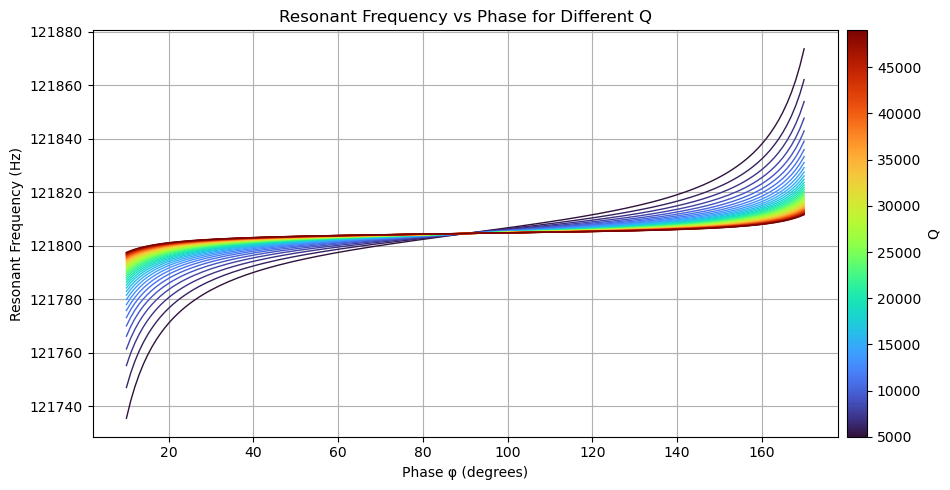

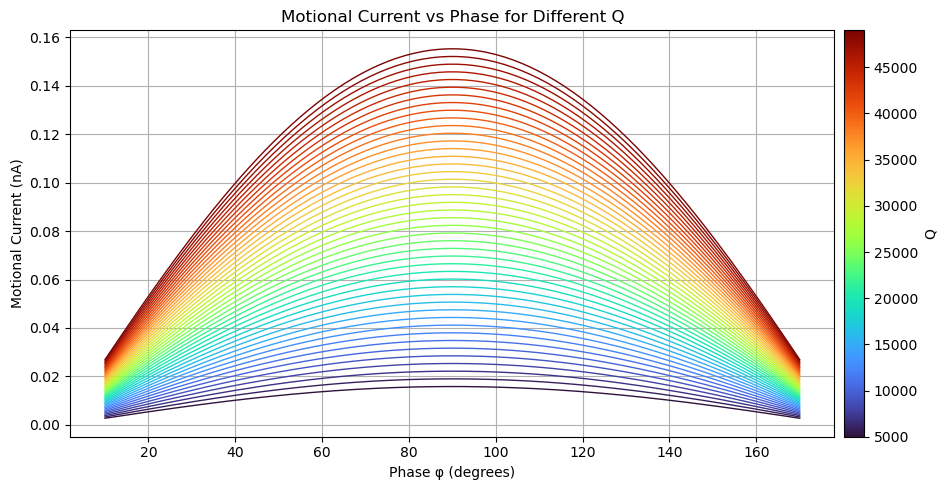

Number of NaN points in freq for each Q: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Number of NaN points in m_c for each Q: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Constants in dataset:


,Constant Name,Value
0,E,169000000000.0
1,rho,2330
2,t,0.000025
3,eps_0,0.0
4,beta,4.73
5,alpha_n,-1.017809
6,w_t,0.00001
7,l_t,0.0005
8,V,5
9,d,0.000006


Variables and results in main dataset:


,Column,Type,Shape
0,Q,int64,-
1,freq,ndarray,"(161,)"
2,m_c,ndarray,"(161,)"


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

with pd.HDFStore('./data/test_Q_45.h5', 'r') as store:
    results_df = store['data']
    constants = store.get_storer('data').attrs.constants
    phi = constants['phi']


Q_values = results_df['Q'].values
phi_deg = phi * 180 / np.pi

# 取颜色映射
norm = plt.Normalize(Q_values.min(), Q_values.max())
cmap = plt.get_cmap('turbo')


fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in results_df.iterrows():
    color = cmap(norm(row['Q']))
    ax.plot(phi_deg, row['freq'], color=color, linewidth=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.set_xlabel('Phase φ (degrees)')
ax.set_ylabel('Resonant Frequency (Hz)')
ax.set_title('Resonant Frequency vs Phase for Different Q')
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Q')
ax.grid(True)
plt.tight_layout()
plt.savefig('results/freq_vs_phase_colorbar_45.png', dpi=150)
plt.show()


# 对 Motional Current 也同理
fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in results_df.iterrows():
    color = cmap(norm(row['Q']))
    ax.plot(phi_deg, row['m_c'], color=color, linewidth=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.set_xlabel('Phase φ (degrees)')
ax.set_ylabel('Motional Current (nA)')
ax.set_title('Motional Current vs Phase for Different Q')
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Q')
ax.grid(True)
plt.tight_layout()
plt.savefig('results/mc_vs_phase_colorbar_45.png', dpi=150)
plt.show()



# Print NaN count for quality check
n_nan_freq = np.array([np.isnan(row['freq']).sum() for _, row in results_df.iterrows()])
n_nan_mc = np.array([np.isnan(row['m_c']).sum() for _, row in results_df.iterrows()])
print("Number of NaN points in freq for each Q:", n_nan_freq)
print("Number of NaN points in m_c for each Q:", n_nan_mc)

# Constants table
const_items = list(constants.items())
const_df = pd.DataFrame(const_items, columns=['Constant Name', 'Value'])
print("Constants in dataset:")
display(const_df)

# DataFrame columns table (variables/results)
col_info = []
for col in results_df.columns:
    col_type = type(results_df[col].iloc[0]).__name__
    if hasattr(results_df[col].iloc[0], '__len__') and not isinstance(results_df[col].iloc[0], str):
        col_shape = np.shape(results_df[col].iloc[0])
    else:
        col_shape = '-'
    col_info.append({'Column': col, 'Type': col_type, 'Shape': col_shape})

col_df = pd.DataFrame(col_info)
print("Variables and results in main dataset:")
display(col_df)

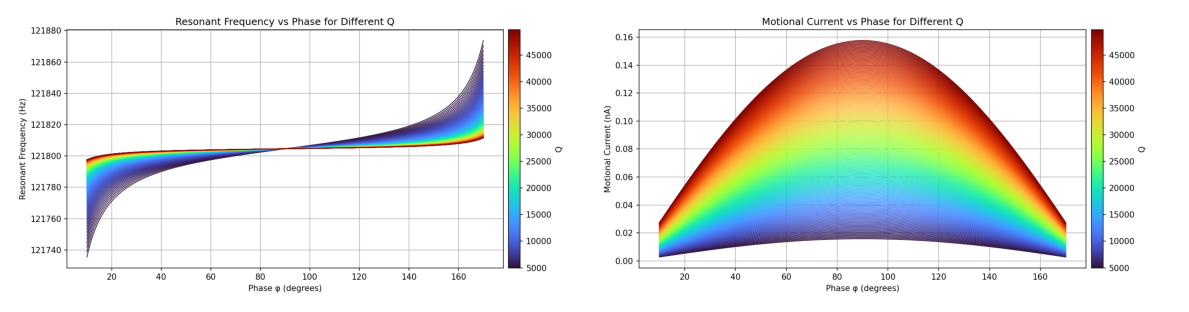

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# 读取图片
img1 = Image.open("./results/freq_vs_phase_colorbar_180.png")
img2 = Image.open("./results/mc_vs_phase_colorbar_180.png")

# 获取图片高度，取最大
h = max(img1.height, img2.height)
# 获取两张图片的宽度总和
w = img1.width + img2.width

# 创建一张新的空白图片（横向拼接，RGB模式）
new_img = Image.new('RGB', (w, h), (255, 255, 255))

# 把两张图片粘贴到新图上
new_img.paste(img1, (0, 0))
new_img.paste(img2, (img1.width, 0))

# 显示或者保存
plt.figure(figsize=(12, 6))
plt.imshow(new_img)
plt.axis('off')
plt.tight_layout()
plt.show()

# 如果你想保存新图片
new_img.save("./integrated_picture/freq_mac_180.png")
